In [1]:
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap


from utils import *
from ardca import *
from classes import *

In [2]:
N_SEQ = 500

In [3]:
msa_path = "../data/PF00014.fasta.gz"
alignment = read_fasta_alignment(msa_path, max_gap_fraction=1.0)
alignment2d, _ = pca_from_onehot(alignment)

# Principal Components Analysis on Samples: Comparing the MSA Sequences with Model Generated Sequences

In [4]:
# sample from MSA
random_indices = np.random.choice(alignment2d.shape[0], size=N_SEQ, replace=False)
random_msa_samples = alignment2d[random_indices]

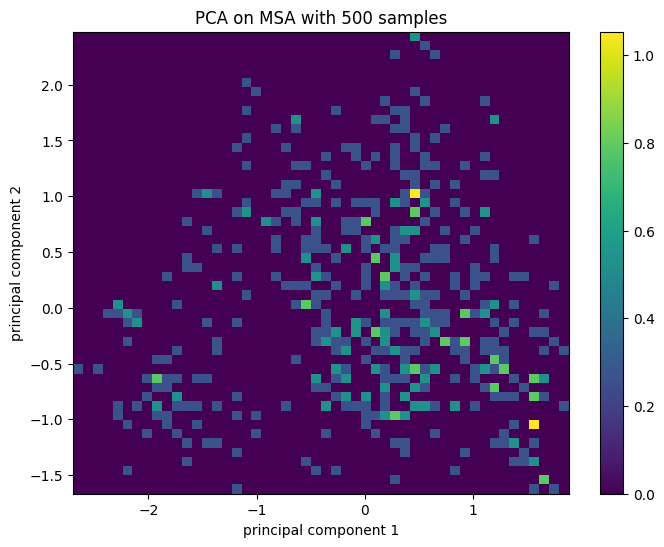

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
h = ax.hist2d(
    random_msa_samples[:, 0],
    random_msa_samples[:, 1],
    bins=50,
    density=True,
)

ax.set(
    title=f"PCA on MSA with {N_SEQ} samples",
    xlabel="principal component 1",
    ylabel="principal component 2",
)

plt.colorbar(h[3], ax=ax)
plt.show()

In [6]:
# sample sequences from model
model = load_ardca_model("models/ardca_PF00014_v1.pt")
generated_seqs = model.sample_sequences(n_samples=N_SEQ, seed=42).numpy()

In [7]:
pca_generated, _ = pca_from_onehot(generated_seqs)

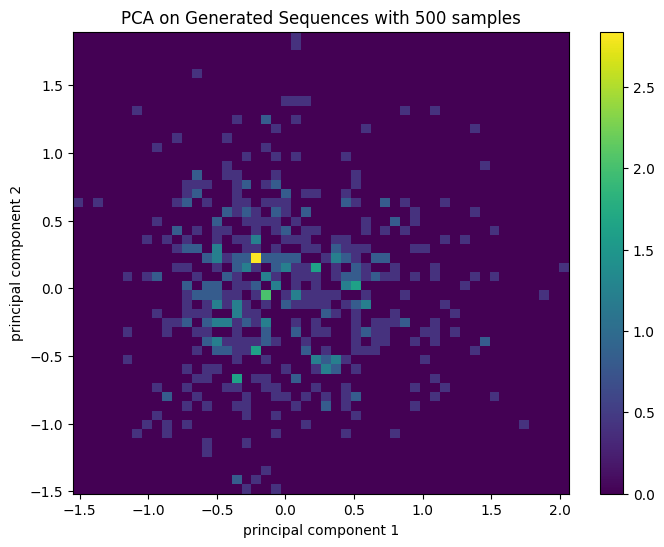

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
h = ax.hist2d(
    pca_generated[:, 0],
    pca_generated[:, 1],
    bins=50,
    density=True,
)

ax.set(
    title=f"PCA on Generated Sequences with {N_SEQ} samples",
    xlabel="principal component 1",
    ylabel="principal component 2",
)

plt.colorbar(h[3], ax=ax)
plt.show()

# UMAP

In [9]:
def umap_from_onehot(idx_mat: np.ndarray, n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean"):
    """
    Perform UMAP on one-hot encoded sequences.
    
    Args:
        idx_mat (np.ndarray): Integer matrix of shape (M, L).
        n_components (int): Number of embedding dimensions.
        n_neighbors (int): Size of local neighborhood (UMAP hyperparameter).
        min_dist (float): Minimum distance between points in low-dim space.
        metric (str): Distance metric (default: 'euclidean').
    
    Returns:
        Z (np.ndarray): UMAP embedding of shape (M, n_components).
        umap_model (umap.UMAP): Fitted UMAP object.
    """
    X = one_hot_for_pca(idx_mat)  # (M, L*q)
    reducer = umap.UMAP(
        init="random",
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42
    )
    Z = reducer.fit_transform(X)
    return Z, reducer

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


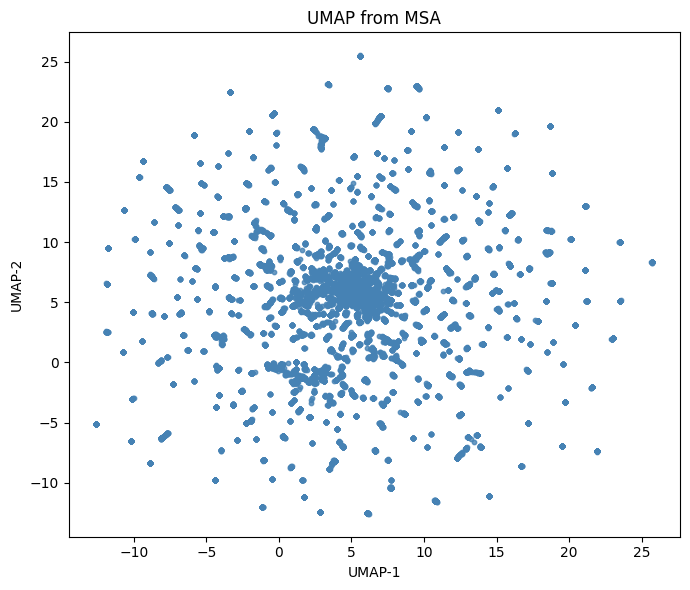

In [10]:
alignment_umap, _ = umap_from_onehot(alignment, n_components=2)
plt.figure(figsize=(7, 6))
plt.scatter(alignment_umap[:, 0], alignment_umap[:, 1], s=10, alpha=0.8, color="steelblue")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP from MSA")
plt.tight_layout()
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


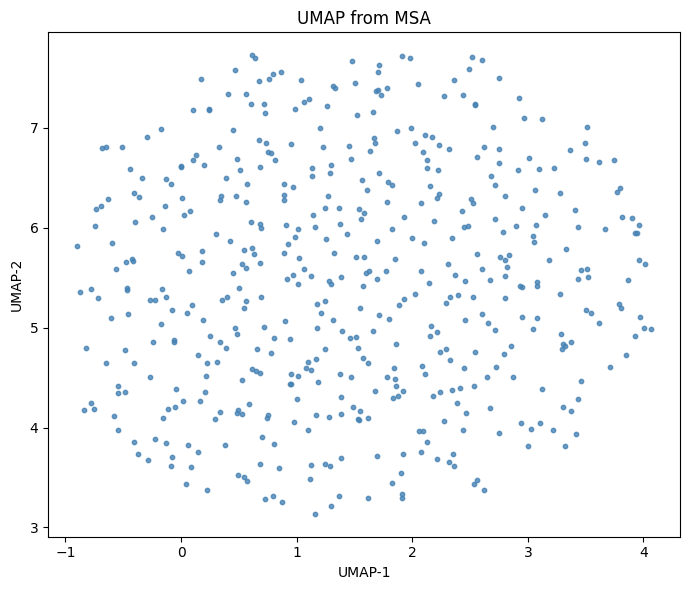

In [11]:
generated_umap, _ = umap_from_onehot(generated_seqs, n_components=2)

plt.figure(figsize=(7, 6))
plt.scatter(generated_umap[:, 0], generated_umap[:, 1], s=10, alpha=0.8, color="steelblue")

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP from MSA")
plt.tight_layout()
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an un

<Figure size 1200x1000 with 0 Axes>

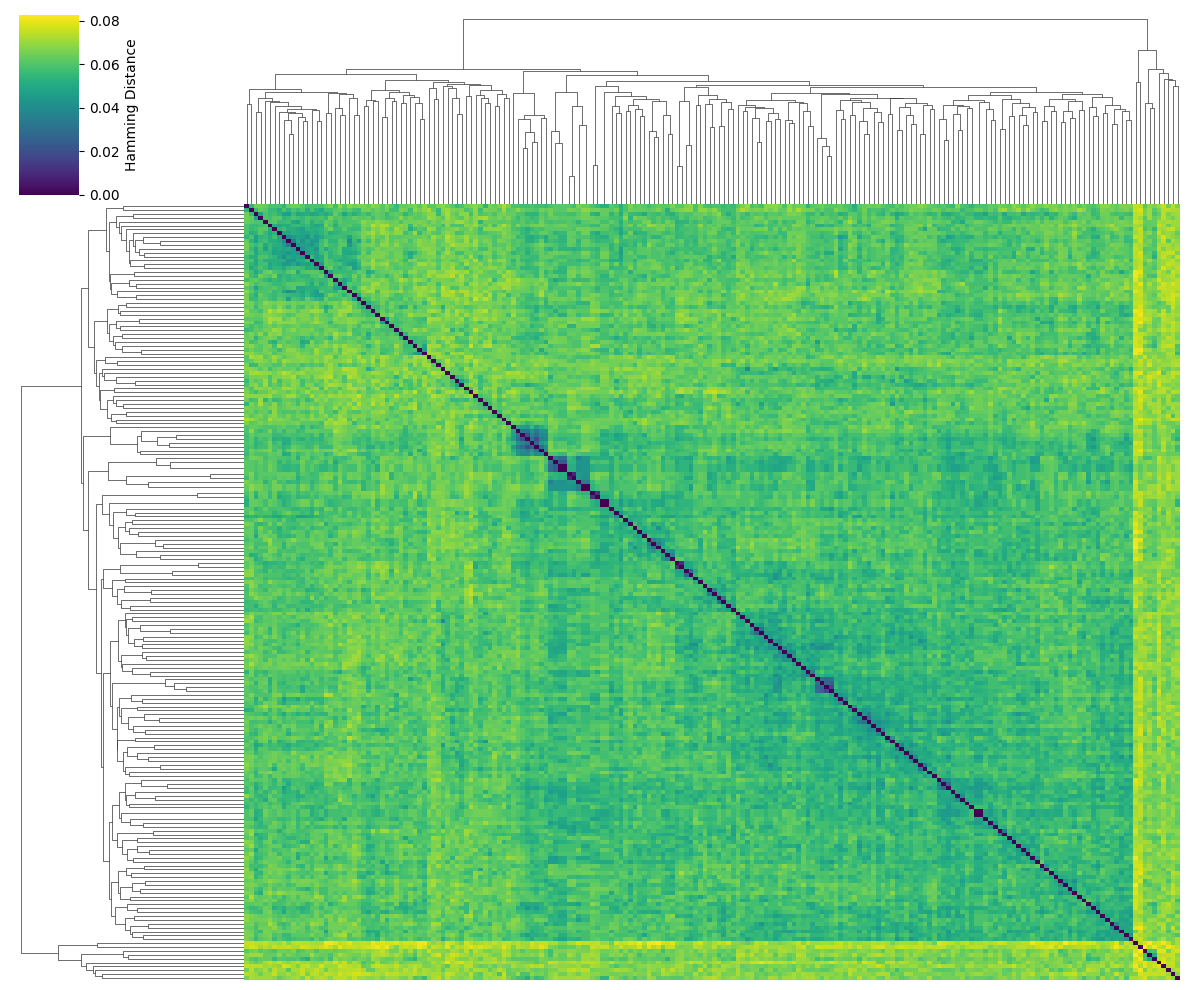

In [12]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

N_SEQ = 200

random_indices = np.random.choice(alignment.shape[0], size=N_SEQ, replace=False)
random_msa_samples = alignment[random_indices]

X = one_hot_for_pca(random_msa_samples)
dist_matrix = pairwise_distances(X, metric="hamming")

plt.figure(figsize=(12, 10))
cluster_grid = sns.clustermap(
    dist_matrix,
    cmap="viridis",
    figsize=(12, 10),
    method="average",  # Use average linkage for clustering
    xticklabels=False, # Hide x-axis labels
    yticklabels=False, # Hide y-axis labels
    cbar_kws={"label": "Hamming Distance"}
)
plt.show()

/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/tommasoferracina/bocconi/thesis/ArDCA-Python/code/.arvenv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an un

<Figure size 1200x1000 with 0 Axes>

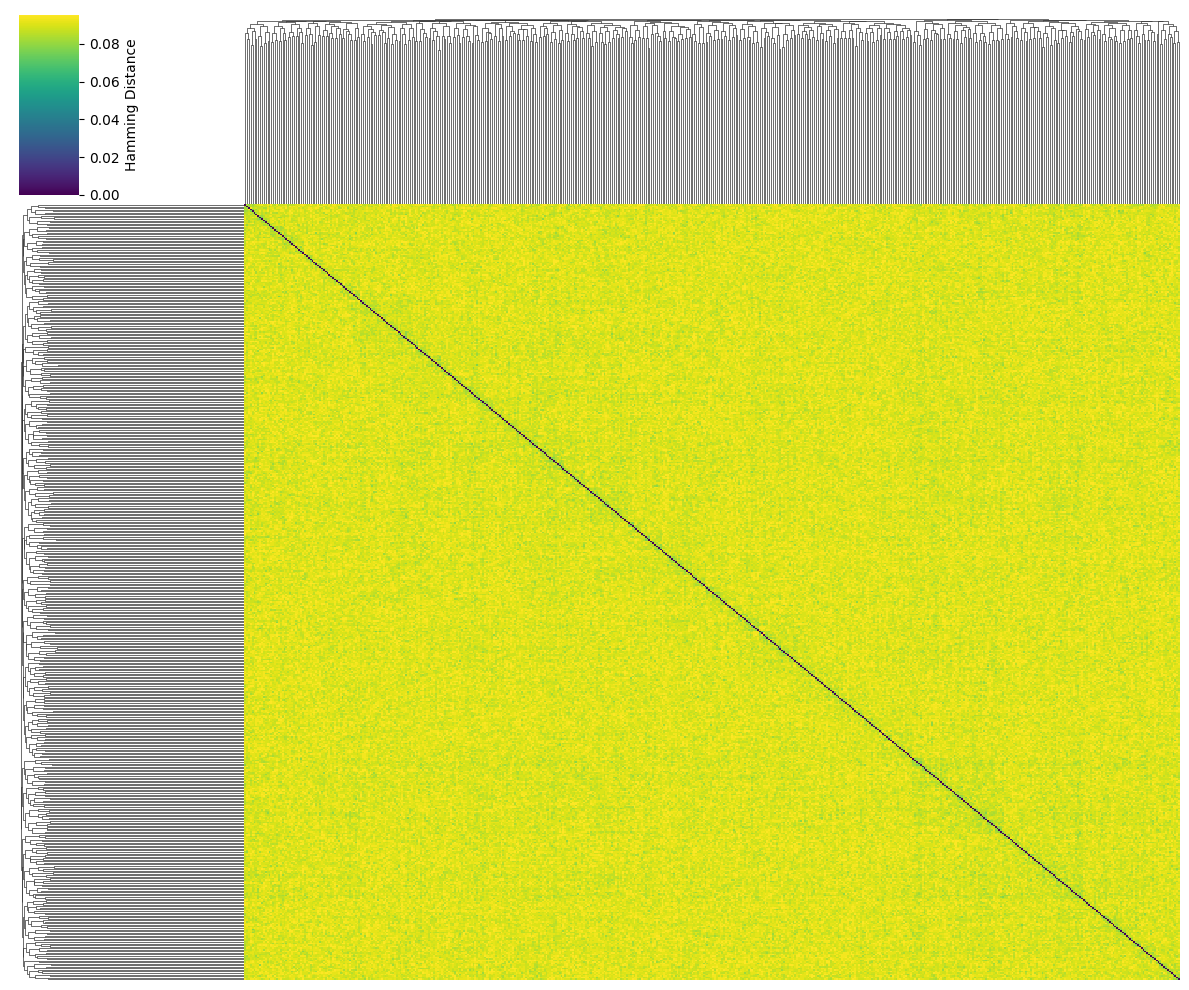

In [13]:
Y = one_hot_for_pca(generated_seqs)
dist_matrix = pairwise_distances(Y, metric="hamming")

plt.figure(figsize=(12, 10))
cluster_grid = sns.clustermap(
    dist_matrix,
    cmap="viridis",
    figsize=(12, 10),
    method="average",  # Use average linkage for clustering
    xticklabels=False, # Hide x-axis labels
    yticklabels=False, # Hide y-axis labels
    cbar_kws={"label": "Hamming Distance"}
)
plt.show()

# Pearson Correlation Between Empirical and Model-Generated Connected Correlations 

In [14]:
# Calculate connected correlations for both MSA and generated sequences
def compute_connected_correlations(sequences):
    """
    Compute connected correlations (Cij) from sequences.
    """
    # Convert to one-hot encoding if not already
    if sequences.ndim == 2:
        one_hot = one_hot_for_pca(sequences)
    else:
        one_hot = sequences
    
    M, L_total = one_hot.shape
    q = 21  # Number of amino acids including gap
    L = L_total // q
    
    # Reshape to (M, L, q)
    x = one_hot.reshape(M, L, q)
    
    # Calculate frequencies (1-point)
    fi = x.mean(axis=0)  # Shape (L, q)
    
    # Calculate pair frequencies (2-point)
    fij = np.zeros((L, L, q, q))
    for i in range(L):
        for j in range(i+1, L):
            for a in range(M):
                for qi in range(q):
                    for qj in range(q):
                        if x[a, i, qi] > 0 and x[a, j, qj] > 0:
                            fij[i, j, qi, qj] += 1
    fij /= M
    
    # Calculate connected correlations
    cij = np.zeros((L, L, q, q))
    for i in range(L):
        for j in range(i+1, L):
            for qi in range(q):
                for qj in range(q):
                    cij[i, j, qi, qj] = fij[i, j, qi, qj] - fi[i, qi] * fi[j, qj]
    
    return cij

In [15]:
# Calculate connected correlations for both datasets
# Use sample of MSA sequences to match the number of generated sequences
msa_sample = alignment[:N_SEQ]
msa_one_hot = one_hot_for_pca(msa_sample)
gen_one_hot = one_hot_for_pca(generated_seqs)

# Compute connected correlations
msa_cij = compute_connected_correlations(msa_sample)
gen_cij = compute_connected_correlations(generated_seqs)

# Flatten the connected correlation matrices for correlation calculation
msa_cij_flat = []
gen_cij_flat = []
L = msa_sample.shape[1]
q = 21

for i in range(L):
    for j in range(i+1, L):
        for qi in range(q):
            for qj in range(q):
                msa_cij_flat.append(msa_cij[i, j, qi, qj])
                gen_cij_flat.append(gen_cij[i, j, qi, qj])

msa_cij_flat = np.array(msa_cij_flat)
gen_cij_flat = np.array(gen_cij_flat)

# Calculate Pearson correlation
from scipy.stats import pearsonr
corr, pval = pearsonr(msa_cij_flat, gen_cij_flat)

print(f"Pearson correlation between MSA and generated connected correlations: {corr:.4f}")
print(f"p-value: {pval:.4e}")

Pearson correlation between MSA and generated connected correlations: 0.0062
p-value: 1.3842e-06


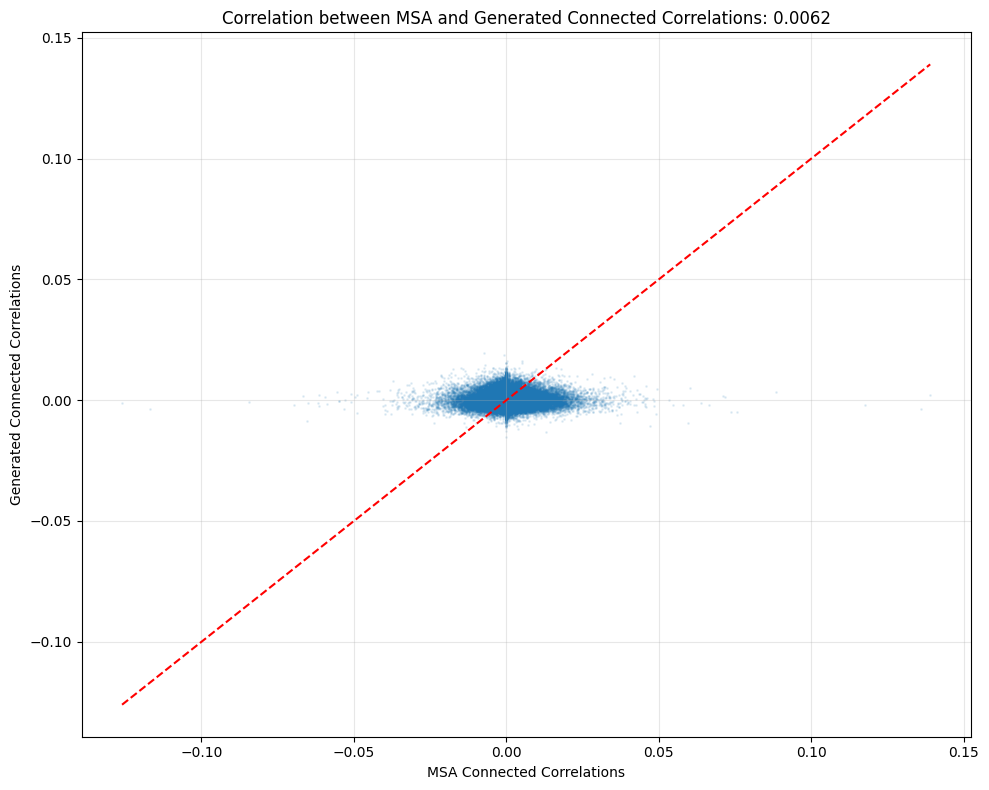

In [16]:
# Visualize the correlation
plt.figure(figsize=(10, 8))
plt.scatter(msa_cij_flat, gen_cij_flat, alpha=0.1, s=1)
plt.xlabel("MSA Connected Correlations")
plt.ylabel("Generated Connected Correlations")
plt.title(f"Correlation between MSA and Generated Connected Correlations: {corr:.4f}")

# Add diagonal line for perfect correlation
min_val = min(msa_cij_flat.min(), gen_cij_flat.min())
max_val = max(msa_cij_flat.max(), gen_cij_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from typing import Tuple, Optional, Dict
from itertools import combinations
import seaborn as sns
from tqdm import tqdm


def compute_single_site_frequencies(sequences: np.ndarray, q: int = 21) -> np.ndarray:
    """
    Compute single-site frequencies f_i(a) for each position and amino acid.
    
    Args:
        sequences: Array of shape (M, L) containing sequence indices
        q: Number of amino acid types (default 21)
        
    Returns:
        frequencies: Array of shape (L, q) with frequencies f_i(a)
    """
    M, L = sequences.shape
    frequencies = np.zeros((L, q))
    
    for i in range(L):
        for a in range(q):
            frequencies[i, a] = np.sum(sequences[:, i] == a) / M
            
    return frequencies


def compute_two_site_correlations(sequences: np.ndarray, q: int = 21) -> np.ndarray:
    """
    Compute two-site correlations C_ij(a,b) = P_ij(a,b) - P_i(a)P_j(b).
    
    Args:
        sequences: Array of shape (M, L) containing sequence indices
        q: Number of amino acid types
        
    Returns:
        correlations: Array of shape (L, L, q, q) with connected correlations
    """
    M, L = sequences.shape
    
    # Compute single-site frequencies
    single_freqs = compute_single_site_frequencies(sequences, q)
    
    # Initialize correlation matrix
    correlations = np.zeros((L, L, q, q))
    
    for i in range(L):
        for j in range(i + 1, L):  # Only compute upper triangle
            for a in range(q):
                for b in range(q):
                    # Joint frequency P_ij(a,b)
                    joint_freq = np.sum((sequences[:, i] == a) & (sequences[:, j] == b)) / M
                    
                    # Connected correlation C_ij(a,b) = P_ij(a,b) - P_i(a)P_j(b)
                    connected_corr = joint_freq - single_freqs[i, a] * single_freqs[j, b]
                    
                    correlations[i, j, a, b] = connected_corr
                    correlations[j, i, b, a] = connected_corr  # Symmetric
    
    return correlations


def compute_three_site_correlations(sequences: np.ndarray, q: int = 21, 
                                  max_triplets: Optional[int] = 1000) -> np.ndarray:
    """
    Compute three-site connected correlations C_ijk(a,b,c).
    
    Args:
        sequences: Array of shape (M, L) containing sequence indices
        q: Number of amino acid types
        max_triplets: Maximum number of triplets to compute (for efficiency)
        
    Returns:
        correlations: Array of shape (n_triplets, q, q, q) with connected correlations
        triplet_indices: Array of shape (n_triplets, 3) with (i,j,k) indices
    """
    M, L = sequences.shape
    
    # Generate all possible triplets or sample if too many
    all_triplets = list(combinations(range(L), 3))
    if max_triplets and len(all_triplets) > max_triplets:
        np.random.seed(42)  # For reproducibility
        selected_indices = np.random.choice(len(all_triplets), max_triplets, replace=False)
        triplets = [all_triplets[i] for i in selected_indices]
    else:
        triplets = all_triplets
    
    n_triplets = len(triplets)
    correlations = np.zeros((n_triplets, q, q, q))
    triplet_indices = np.array(triplets)
    
    # Compute single and two-site frequencies
    single_freqs = compute_single_site_frequencies(sequences, q)
    two_site_corrs = compute_two_site_correlations(sequences, q)
    
    for t_idx, (i, j, k) in enumerate(tqdm(triplets, desc="Computing 3-site correlations")):
        for a in range(q):
            for b in range(q):
                for c in range(q):
                    # Joint frequency P_ijk(a,b,c)
                    joint_freq = np.sum((sequences[:, i] == a) & 
                                      (sequences[:, j] == b) & 
                                      (sequences[:, k] == c)) / M
                    
                    # Connected correlation C_ijk(a,b,c) = P_ijk(a,b,c) - P_i(a)P_j(b)P_k(c)
                    # - C_ij(a,b)P_k(c) - C_ik(a,c)P_j(b) - C_jk(b,c)P_i(a)
                    independent_term = (single_freqs[i, a] * single_freqs[j, b] * single_freqs[k, c])
                    
                    two_site_terms = (two_site_corrs[i, j, a, b] * single_freqs[k, c] +
                                    two_site_corrs[i, k, a, c] * single_freqs[j, b] +
                                    two_site_corrs[j, k, b, c] * single_freqs[i, a])
                    
                    connected_corr = joint_freq - independent_term - two_site_terms
                    correlations[t_idx, a, b, c] = connected_corr
    
    return correlations, triplet_indices


def extract_nonzero_correlations(correlations: np.ndarray, 
                                threshold: float = 1e-10) -> np.ndarray:
    """
    Extract non-zero correlation values from correlation tensor.
    
    Args:
        correlations: Correlation tensor
        threshold: Minimum absolute value to consider non-zero
        
    Returns:
        Non-zero correlation values as 1D array
    """
    flat_corrs = correlations.flatten()
    return flat_corrs[np.abs(flat_corrs) > threshold]


def plot_correlation_comparison(data_corrs: np.ndarray, 
                              model_corrs: np.ndarray,
                              correlation_type: str = "Two-site",
                              figsize: Tuple[int, int] = (8, 6),
                              color: str = 'blue',
                              alpha: float = 0.6,
                              s: float = 1.0) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot correlation comparison between data and model samples.
    
    Args:
        data_corrs: Correlations from real data
        model_corrs: Correlations from model samples
        correlation_type: Type of correlation for labeling
        figsize: Figure size
        color: Point color
        alpha: Point transparency
        s: Point size
        
    Returns:
        Figure and axes objects
    """
    # Extract non-zero correlations
    data_flat = extract_nonzero_correlations(data_corrs)
    model_flat = extract_nonzero_correlations(model_corrs)
    
    # Ensure same length by taking minimum
    min_len = min(len(data_flat), len(model_flat))
    data_flat = data_flat[:min_len]
    model_flat = model_flat[:min_len]
    
    # Compute statistics
    correlation, p_value = pearsonr(data_flat, model_flat)
    slope = np.polyfit(data_flat, model_flat, 1)[0]
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot
    ax.scatter(data_flat, model_flat, alpha=alpha, s=s, color=color, 
              label=f'arDCA, Pearson: {correlation:.2f}\nSlope: {slope:.2f}')
    
    # Perfect correlation line
    min_val = min(np.min(data_flat), np.min(model_flat))
    max_val = max(np.max(data_flat), np.max(model_flat))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=1)
    
    # Fitted line
    fit_line = slope * data_flat + (np.mean(model_flat) - slope * np.mean(data_flat))
    sorted_idx = np.argsort(data_flat)
    ax.plot(data_flat[sorted_idx], fit_line[sorted_idx], color=color, alpha=0.8, linewidth=1)
    
    # Formatting
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel('Sample', fontsize=12)
    ax.set_title(f'{correlation_type} Connected Correlations', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    return fig, ax


def comprehensive_correlation_analysis(data_sequences: np.ndarray,
                                     model_sequences: np.ndarray,
                                     q: int = 21,
                                     max_triplets: Optional[int] = 500,
                                     figsize: Tuple[int, int] = (15, 5)) -> Dict:
    """
    Perform comprehensive correlation analysis and create comparison plots.
    
    Args:
        data_sequences: Real MSA sequences of shape (M_data, L)
        model_sequences: Model-generated sequences of shape (M_model, L)
        q: Number of amino acid types
        max_triplets: Maximum triplets for 3-site correlations
        figsize: Figure size for the combined plot
        
    Returns:
        Dictionary containing all computed correlations and statistics
    """
    print("Computing single-site frequencies...")
    data_f1 = compute_single_site_frequencies(data_sequences, q)
    model_f1 = compute_single_site_frequencies(model_sequences, q)
    
    print("Computing two-site correlations...")
    data_c2 = compute_two_site_correlations(data_sequences, q)
    model_c2 = compute_two_site_correlations(model_sequences, q)
    
    print("Computing three-site correlations...")
    data_c3, triplet_indices = compute_three_site_correlations(data_sequences, q, max_triplets)
    model_c3, _ = compute_three_site_correlations(model_sequences, q, max_triplets)
    
    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Single-site frequencies
    data_f1_flat = data_f1.flatten()
    model_f1_flat = model_f1.flatten()
    nonzero_mask = data_f1_flat > 1e-6  # Only non-zero frequencies
    
    corr_f1, _ = pearsonr(data_f1_flat[nonzero_mask], model_f1_flat[nonzero_mask])
    slope_f1 = np.polyfit(data_f1_flat[nonzero_mask], model_f1_flat[nonzero_mask], 1)[0]
    
    axes[0].scatter(data_f1_flat[nonzero_mask], model_f1_flat[nonzero_mask], 
                   alpha=0.6, s=2, color='blue')
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=1)
    axes[0].set_xlabel('Data')
    axes[0].set_ylabel('Sample')
    axes[0].set_title('$F_i$')
    axes[0].text(0.05, 0.95, f'arDCA, Pearson: {corr_f1:.1f}\nSlope: {slope_f1:.2f}', 
                transform=axes[0].transAxes, verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0].grid(True, alpha=0.3)
    
    # Two-site correlations
    data_c2_flat = extract_nonzero_correlations(data_c2)
    model_c2_flat = extract_nonzero_correlations(model_c2)
    min_len = min(len(data_c2_flat), len(model_c2_flat))
    
    corr_c2, _ = pearsonr(data_c2_flat[:min_len], model_c2_flat[:min_len])
    slope_c2 = np.polyfit(data_c2_flat[:min_len], model_c2_flat[:min_len], 1)[0]
    
    axes[1].scatter(data_c2_flat[:min_len], model_c2_flat[:min_len], 
                   alpha=0.4, s=1, color='blue')
    min_val = min(np.min(data_c2_flat[:min_len]), np.min(model_c2_flat[:min_len]))
    max_val = max(np.max(data_c2_flat[:min_len]), np.max(model_c2_flat[:min_len]))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=1)
    axes[1].set_xlabel('Data')
    axes[1].set_ylabel('Sample')
    axes[1].set_title('$C_{ij}$')
    axes[1].text(0.05, 0.95, f'arDCA, Pearson: {corr_c2:.1f}\nSlope: {slope_c2:.2f}', 
                transform=axes[1].transAxes, verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1].grid(True, alpha=0.3)
    
    # Three-site correlations
    data_c3_flat = extract_nonzero_correlations(data_c3)
    model_c3_flat = extract_nonzero_correlations(model_c3)
    min_len = min(len(data_c3_flat), len(model_c3_flat))
    
    corr_c3, _ = pearsonr(data_c3_flat[:min_len], model_c3_flat[:min_len])
    slope_c3 = np.polyfit(data_c3_flat[:min_len], model_c3_flat[:min_len], 1)[0]
    
    axes[2].scatter(data_c3_flat[:min_len], model_c3_flat[:min_len], 
                   alpha=0.4, s=1, color='blue')
    min_val = min(np.min(data_c3_flat[:min_len]), np.min(model_c3_flat[:min_len]))
    max_val = max(np.max(data_c3_flat[:min_len]), np.max(model_c3_flat[:min_len]))
    axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, linewidth=1)
    axes[2].set_xlabel('Data')
    axes[2].set_ylabel('Sample')
    axes[2].set_title('$C_{ijk}$')
    axes[2].text(0.05, 0.95, f'arDCA, Pearson: {corr_c3:.1f}\nSlope: {slope_c3:.2f}', 
                transform=axes[2].transAxes, verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return results dictionary
    results = {
        'single_site_freqs': {
            'data': data_f1,
            'model': model_f1,
            'pearson': corr_f1,
            'slope': slope_f1
        },
        'two_site_corrs': {
            'data': data_c2,
            'model': model_c2,
            'pearson': corr_c2,
            'slope': slope_c2
        },
        'three_site_corrs': {
            'data': data_c3,
            'model': model_c3,
            'pearson': corr_c3,
            'slope': slope_c3,
            'triplet_indices': triplet_indices
        },
        'figure': fig
    }
    
    return results


Computing single-site frequencies...
Computing two-site correlations...
Computing three-site correlations...


Computing 3-site correlations: 100%|██████████| 200/200 [00:17<00:00, 11.26it/s]


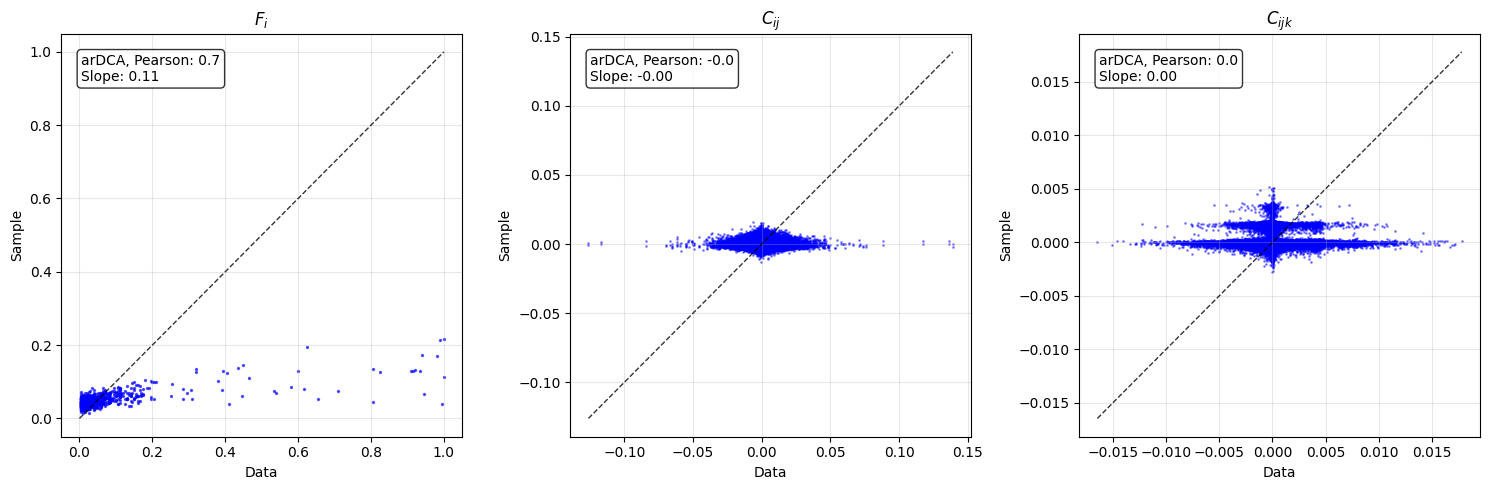

Single-site correlation: 0.713
Two-site correlation: -0.001
Three-site correlation: 0.001


{'single_site_freqs': {'data': array([[0.41 , 0.04 , 0.   , ..., 0.16 , 0.   , 0.   ],
         [0.005, 0.   , 0.995, ..., 0.   , 0.   , 0.   ],
         [0.005, 0.055, 0.   , ..., 0.025, 0.005, 0.045],
         ...,
         [0.01 , 0.13 , 0.   , ..., 0.105, 0.   , 0.05 ],
         [0.01 , 0.   , 0.99 , ..., 0.   , 0.   , 0.   ],
         [0.625, 0.04 , 0.   , ..., 0.   , 0.   , 0.   ]], shape=(53, 21)),
  'model': array([[0.038, 0.038, 0.03 , ..., 0.042, 0.058, 0.048],
         [0.044, 0.032, 0.038, ..., 0.048, 0.056, 0.042],
         [0.04 , 0.046, 0.052, ..., 0.062, 0.03 , 0.058],
         ...,
         [0.038, 0.088, 0.04 , ..., 0.038, 0.018, 0.036],
         [0.05 , 0.036, 0.214, ..., 0.038, 0.028, 0.046],
         [0.196, 0.046, 0.036, ..., 0.044, 0.034, 0.034]], shape=(53, 21)),
  'pearson': np.float64(0.7128922715108245),
  'slope': np.float64(0.1055602527240425)},
 'two_site_corrs': {'data': array([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
             0.000

In [18]:
# Run comprehensive analysis
results = comprehensive_correlation_analysis(
    msa_sample, 
    generated_seqs, 
    q=q,
    max_triplets=200
)

# Print summary statistics
print(f"Single-site correlation: {results['single_site_freqs']['pearson']:.3f}")
print(f"Two-site correlation: {results['two_site_corrs']['pearson']:.3f}")
print(f"Three-site correlation: {results['three_site_corrs']['pearson']:.3f}")

results